# Code Execution

In [3]:
from pathlib import Path

from autogen.coding import CodeBlock, DockerCommandLineCodeExecutor

work_dir = Path("coding")
work_dir.mkdir(exist_ok=True)

with DockerCommandLineCodeExecutor(work_dir=work_dir) as executor:
    print(
        executor.execute_code_blocks(
            code_blocks=[
                CodeBlock(language="python", code="print('Hello, World!')"),
            ]
        )
    )

exit_code=0 output='Hello, World!\n' code_file='coding\\tmp_code_07da107bb575cc4e02b0e1d6d99cc204.python'


In [4]:
from pathlib import Path

from autogen.coding import CodeBlock, LocalCommandLineCodeExecutor

work_dir = Path("coding")
work_dir.mkdir(exist_ok=True)

executor = LocalCommandLineCodeExecutor(work_dir=work_dir)
print(
    executor.execute_code_blocks(
        code_blocks=[
            CodeBlock(language="python", code="print('Hello, World!')"),
        ]
    )
)

exit_code=0 output='Hello, World!\n' code_file='C:\\Users\\sides\\AppData\\Local\\Programs\\Microsoft VS Code\\coding\\tmp_code_07da107bb575cc4e02b0e1d6d99cc204.py'


In [5]:
from autogen.code_utils import create_virtual_env
from autogen.coding import CodeBlock, LocalCommandLineCodeExecutor

venv_dir = ".venv"
venv_context = create_virtual_env(venv_dir)

executor = LocalCommandLineCodeExecutor(virtual_env_context=venv_context)
print(
    executor.execute_code_blocks(code_blocks=[CodeBlock(language="python", code="import sys; print(sys.executable)")])
)

Actual environment location may have moved due to redirects, links or junctions.
  Requested location: ".venv\Scripts\python.exe"
  Actual location:    "C:\Users\sides\AppData\Local\Programs\Microsoft VS Code\.venv\Scripts\python.exe"


exit_code=0 output='c:\\Users\\sides\\AppData\\Local\\Programs\\Microsoft VS Code\\.venv\\Scripts\\python.exe\n' code_file='C:\\Users\\sides\\AppData\\Local\\Programs\\Microsoft VS Code\\tmp_code_278b725fd664fea2ecbf552b6b17cf04.py'


In [6]:
from pathlib import Path

from autogen import ConversableAgent
from autogen.coding import DockerCommandLineCodeExecutor

work_dir = Path("coding")
work_dir.mkdir(exist_ok=True)

executor = DockerCommandLineCodeExecutor(work_dir=work_dir)

code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={
        "executor": executor,
    },
    human_input_mode="NEVER",
)

In [9]:
# The code writer agent's system message is to instruct the LLM on how to
# use the Jupyter code executor with IPython kernel.
code_writer_system_message = """
You have been given coding capability to solve tasks using Python code.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feedback or perform any other action beyond executing the code you suggest. The user can't modify your code. So do not suggest incomplete code which requires users to modify. Don't use a code block if it's not intended to be executed by the user.
If you want the user to save the code in a file before executing it, put # filename: <filename> inside the code block as the first line. Don't include multiple code blocks in one response. Do not ask users to copy and paste the result. Instead, use 'print' function for the output when relevant. Check the execution result returned by the user.
"""

import os

code_writer_agent = ConversableAgent(
    "code_writer",
    system_message=code_writer_system_message,
    llm_config={"config_list": [{"model": "gpt-4", "api_key":"API_KEY_PLACEHOLDERproj-8jhaENcxBVVg8iAhSEQBT3BlbkFJ7S6mDafUVTonpaZWq7X1"}]},
    code_execution_config=False,  # Turn off code execution for this agent.
    max_consecutive_auto_reply=2,
    human_input_mode="NEVER",
)

In [10]:
import pprint

chat_result = code_executor_agent.initiate_chat(
    code_writer_agent, message="Write Python code to calculate the 14th Fibonacci number."
)

pprint.pprint(chat_result)

code_executor_agent (to code_writer):

Write Python code to calculate the 14th Fibonacci number.

--------------------------------------------------------------------------------
code_writer (to code_executor_agent):

Sure, I can help with that. 

The Fibonacci sequence is a sequence of numbers where each number after the first two is the sum of the two preceding ones. The sequence starts as: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, ....

We can calculate the 14th number in the Fibonacci series using Python in several ways. Here, I would suggest the iterative approach as it's efficient for large numbers. 

The Python code is provided below:

```python
def fibonacci(n):
    fib = [0, 1] + [0] * (n - 1)
    for i in range(2, n + 1):
        fib[i] = fib[i - 1] + fib[i - 2]
    return fib[n]

print(fibonacci(14))
```

This script will calculate and print the 14th Fibonacci number. The function `fibonacci(n)` calculates the nth Fibonacci number, and `print(fibonacci(14))` will print out the 14th F

In [11]:
executor.stop()

# Custom Code Executor

In [12]:
import os
from typing import List

from IPython import get_ipython

from autogen import ConversableAgent
from autogen.coding import CodeBlock, CodeExecutor, CodeExtractor, CodeResult, MarkdownCodeExtractor

In [13]:
class NotebookExecutor(CodeExecutor):

    @property
    def code_extractor(self) -> CodeExtractor:
        # Extact code from markdown blocks.
        return MarkdownCodeExtractor()

    def __init__(self) -> None:
        # Get the current IPython instance running in this notebook.
        self._ipython = get_ipython()

    def execute_code_blocks(self, code_blocks: List[CodeBlock]) -> CodeResult:
        log = ""
        for code_block in code_blocks:
            result = self._ipython.run_cell("%%capture --no-display cap\n" + code_block.code)
            log += self._ipython.ev("cap.stdout")
            log += self._ipython.ev("cap.stderr")
            if result.result is not None:
                log += str(result.result)
            exitcode = 0 if result.success else 1
            if result.error_before_exec is not None:
                log += f"\n{result.error_before_exec}"
                exitcode = 1
            if result.error_in_exec is not None:
                log += f"\n{result.error_in_exec}"
                exitcode = 1
            if exitcode != 0:
                break
        return CodeResult(exit_code=exitcode, output=log)

In [15]:
code_writer_agent = ConversableAgent(
    name="CodeWriter",
    system_message="You are a helpful AI assistant.\n"
    "You use your coding skill to solve problems.\n"
    "You have access to a IPython kernel to execute Python code.\n"
    "You can suggest Python code in Markdown blocks, each block is a cell.\n"
    "The code blocks will be executed in the IPython kernel in the order you suggest them.\n"
    "All necessary libraries have already been installed.\n"
    "Once the task is done, returns 'TERMINATE'.",
    llm_config={"config_list": [{"model": "gpt-4", "api_key":"API_KEY_PLACEHOLDERproj-8jhaENcxBVVg8iAhSEQBT3BlbkFJ7S6mDafUVTonpaZWq7X1"}]},
)

code_executor_agent = ConversableAgent(
    name="CodeExecutor",
    llm_config=False,
    code_execution_config={"executor": NotebookExecutor()},
    is_termination_msg=lambda msg: "TERMINATE" in msg.get("content", "").strip().upper(),
)

In [16]:
code_writer_agent = ConversableAgent(
    name="CodeWriter",
    system_message="You are a helpful AI assistant.\n"
    "You use your coding skill to solve problems.\n"
    "You have access to a IPython kernel to execute Python code.\n"
    "You can suggest Python code in Markdown blocks, each block is a cell.\n"
    "The code blocks will be executed in the IPython kernel in the order you suggest them.\n"
    "All necessary libraries have already been installed.\n"
    "Once the task is done, returns 'TERMINATE'.",
    llm_config={"config_list": [{"model": "gpt-4", "api_key":"API_KEY_PLACEHOLDERproj-8jhaENcxBVVg8iAhSEQBT3BlbkFJ7S6mDafUVTonpaZWq7X1"}]},
)

code_executor_agent = ConversableAgent(
    name="CodeExecutor",
    llm_config=False,
    code_execution_config={"executor": NotebookExecutor()},
    is_termination_msg=lambda msg: "TERMINATE" in msg.get("content", "").strip().upper(),
)

CodeExecutor (to CodeWriter):

Create a plot showing the market caps of the top 7 publicly listed companies using data from Yahoo Finance.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
CodeWriter (to CodeExecutor):

Alright. First, we need to import the necessary Python libraries for web scraping and data handling. We are going to use the following:

- pandas: To create and manipulate dataframes
- requests: To send HTTP requests (in our case, we will send a GET request to Yahoo Finance)
- bs4 (BeautifulSoup): To parse HTML and XML documents (in our case, we will parse the Yahoo Finance webpage's HTML)
- matplotlib: To create the plot

We also have to identify the top 7 publicly listed companies. However, this information might vary depending on the date and criteria considered. Since the task doesn't specify, we will consider the companies with highest market capitalization.

Let’s first get data from Yahoo Finance with 

,Company,Market Cap


CodeExecutor (to CodeWriter):

exitcode: 0 (execution succeeded)
Code output: 

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
CodeWriter (to CodeExecutor):

It seems like there was an issue with the code output. Unfortunately, I can't see the execution results directly.

We should be having a DataFrame now. However, the 'Market Cap' column might contain non-numeric characters like 'M' (Mega, 10^6) for millions, 'B' (Giga, 10^9) for billions, 'T' (Tera, 10^12) for trillions and 'k' (Kilo, 10^3) for thousands in the end of the values. We want to get rid of these characters and convert the numbers represented as string types to float types, so that we can sort, filter and visualize this column.

We also might have more than seven companies in our DataFrame. We want to keep only the top 7 companies by market capitalization.

Let's create a function to convert these values to numeric format and filter the top 7 companies.

Ple

,Company,Market Cap


CodeExecutor (to CodeWriter):

exitcode: 0 (execution succeeded)
Code output: 

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
CodeWriter (to CodeExecutor):

Great! Now that we have the market cap data for the top 7 companies, we can plot this information. We will use a horizontal bar chart for this task. The company names will be on the y axis and the corresponding market caps will be on the x axis.

Please, execute the following code block to generate the plot.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
CodeExecutor (to CodeWriter):



--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
CodeWriter (to CodeExecutor):

```python
# Set the style of the plot
plt.style.use('ggplot')

# Create a horizontal bar plot
plt.barh(df['Company'], df['Market Cap'], color='blue')

# Invert the y-axis to have th

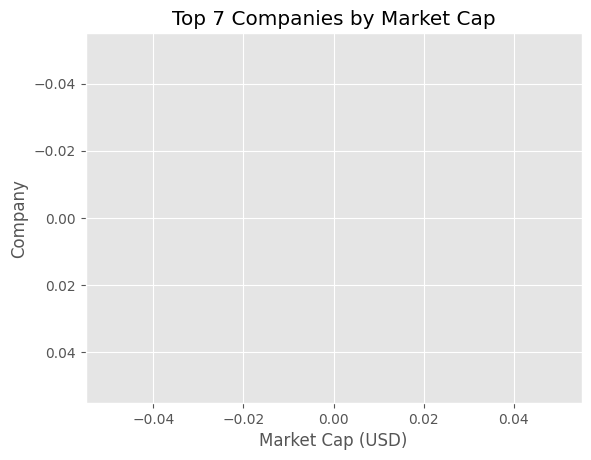

CodeExecutor (to CodeWriter):

exitcode: 0 (execution succeeded)
Code output: 

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
CodeWriter (to CodeExecutor):

Return 'TERMINATE'.

--------------------------------------------------------------------------------

>>>>>>>> NO HUMAN INPUT RECEIVED.


In [17]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message="Create a plot showing the market caps of the top 7 publicly listed companies using data from Yahoo Finance.",
)

# Kubernetes Pod Commandline Code Executor

In [18]:
import os

# Set the KUBECONFIG environment variable
# if the kubeconfig file is not in the default location(~/.kube/config).
os.environ["KUBECONFIG"] = "path/to/your/kubeconfig"

In [31]:
from autogen.agentchat.contrib.capabilities.text_compressors import LLMLingua


In [1]:
import tempfile

import fitz  # PyMuPDF
import requests

from autogen.agentchat.contrib.capabilities.text_compressors import LLMLingua
from autogen.agentchat.contrib.capabilities.transforms import TextMessageCompressor

AUTOGEN_PAPER = "https://arxiv.org/pdf/2308.08155"


def extract_text_from_pdf():
    # Download the PDF
    response = requests.get(AUTOGEN_PAPER)
    response.raise_for_status()  # Ensure the download was successful

    text = ""
    # Save the PDF to a temporary file
    with tempfile.TemporaryDirectory() as temp_dir:
        with open(temp_dir + "temp.pdf", "wb") as f:
            f.write(response.content)

        # Open the PDF
        with fitz.open(temp_dir + "temp.pdf") as doc:
            # Read and extract text from each page
            for page in doc:
                text += page.get_text()

    return text


# Example usage
pdf_text = extract_text_from_pdf()

llm_lingua = LLMLingua()
text_compressor = TextMessageCompressor(text_compressor=llm_lingua)
compressed_text = text_compressor.apply_transform([{"content": pdf_text}])

print(text_compressor.get_logs([], []))

c:\Users\sides\.conda\envs\autogen\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
flaml.automl is not available. Please install flaml[automl] to enable AutoML functionalities.
c:\Users\sides\.conda\envs\autogen\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sides\.cache\huggingface\hub\models--microsoft--llmlingua-2-bert-base-multilingual-cased-meetingbank. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To su

('19765 tokens saved with text compression.', True)


In [3]:
import os

import autogen
from autogen.agentchat.contrib.capabilities import transform_messages

system_message = "You are a world class researcher."
config_list = [{"model": "gpt-4-turbo", "api_key":"API_KEY_PLACEHOLDERproj-8jhaENcxBVVg8iAhSEQBT3BlbkFJ7S6mDafUVTonpaZWq7X1"}]

# Define your agent; the user proxy and an assistant
researcher = autogen.ConversableAgent(
    "assistant",
    llm_config={"config_list": config_list},
    max_consecutive_auto_reply=1,
    system_message=system_message,
    human_input_mode="NEVER",
)
user_proxy = autogen.UserProxyAgent(
    "user_proxy",
    human_input_mode="NEVER",
    is_termination_msg=lambda x: "TERMINATE" in x.get("content", ""),
    max_consecutive_auto_reply=1,
)